# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [31]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [33]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.320051
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *loss = - log(0.1) then loss ~= 0.0 *


In [34]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.105939 analytic: -0.105939, relative error: 1.379350e-07
numerical: 2.709881 analytic: 2.709881, relative error: 7.971770e-09
numerical: -0.756854 analytic: -0.756854, relative error: 2.223588e-08
numerical: 0.389927 analytic: 0.389927, relative error: 3.882602e-08
numerical: 1.953167 analytic: 1.953167, relative error: 1.597836e-08
numerical: 1.058762 analytic: 1.058762, relative error: 2.390977e-08
numerical: -0.637656 analytic: -0.637656, relative error: 1.522073e-08
numerical: -0.733122 analytic: -0.733122, relative error: 3.864215e-08
numerical: 0.942860 analytic: 0.942859, relative error: 1.577682e-08
numerical: 0.487990 analytic: 0.487990, relative error: 2.420450e-08
numerical: -0.535498 analytic: -0.535498, relative error: 3.867095e-08
numerical: -0.687043 analytic: -0.687043, relative error: 1.469953e-08
numerical: 2.671912 analytic: 2.671912, relative error: 1.819052e-08
numerical: -0.057841 analytic: -0.057841, relative error: 3.573711e-07
numerical: 0.660454 

In [35]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.320051e+00 computed in 0.250951s
vectorized loss: 2.320051e+00 computed in 0.019510s
Loss difference: 0.000000
Gradient difference: 0.000000


In [30]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
# experiment 2

lr_step = 1e-8
reg_step = 1e4

learning_rates = np.arange(0,5001,250)*lr_step
learning_rates[0] += lr_step

learning_rates = [1.0,0.1,0.01,0.001,0.0001,0.00001,1e-6,1e-7,1e-8]
#print learning_rates

#print regularization_strengths
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.


# other hyperparameters????
num_iters = 100 # default value actually
# how about batch_size??? # default value 200

# reload data
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Test data shape: ', X_test.shape

# @@@@ without subtraction, the accuracy is terriblely bad.@@@@
# subtract 
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image

X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
print 'After hstack, Training data shape: ', X_train.shape
print 'After hstack, Test data shape: ', X_test.shape

# validation set size is 1000, so get num_folds = 50000 / 1000
num_folds = 5

# init some values
val_accuracy = 0.0
tr_accuracy = 0.0
val_accuracy_sum = 0.0
tr_accuracy_sum = 0.0

X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)

tic = time.time()
fo = open("validation_output_softmax.txt", "ab+")
for reg in regularization_strengths:
    for lr in learning_rates:
        softmax = Softmax()
        val_accuracy_sum = 0.0
        tr_accuracy_sum = 0.0
        str1_all = ""
        for i in range(num_folds):
            X_tr = X_train_folds[0:i] + X_train_folds[(i+1):num_folds]
            X_tr = np.reshape(X_tr,(X_train.shape[0]*(num_folds-1)/num_folds,-1))
            y_tr = y_train_folds[0:i] + y_train_folds[(i+1):num_folds]
            y_tr = np.reshape(y_tr,(X_train.shape[0]*(num_folds-1)/num_folds))
            X_val = np.reshape(X_train_folds[i],(X_train.shape[0]*1/num_folds,-1))
            
            loss_hist_tr = softmax.train(X_tr,y_tr,learning_rate=lr,reg=reg,num_iters=num_iters,verbose=False)
            y_train_pred = softmax.predict(X_tr.T)
            y_val_pred = softmax.predict(X_val.T)
            val_accuracy = np.mean(y_train_folds[i] == y_val_pred)
            tr_accuracy = np.mean(y_tr == y_train_pred)
            str1 = '@@@@@validation@@@@@ lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, tr_accuracy, val_accuracy)
            print str1
            str1_all += (str1+"\n")
            val_accuracy_sum += val_accuracy
            tr_accuracy_sum += tr_accuracy
            
        str2 = "End one validation.....\n"
        print str2
        val_accuracy = val_accuracy_sum/float(num_folds)
        tr_accuracy = tr_accuracy_sum/float(num_folds)
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_softmax = softmax
        results[(lr,reg)] = (tr_accuracy,val_accuracy)
        str3 = "one combination...." + str(results[(lr,reg)]) + "\n"
        print str3
        str_write = str1 + "\n" + str2 + "\n" + str3 + "\n"
        fo.writelines(str_write)
fo.close()

str_sorted = ""
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    str_sorted += 'lr %e reg %e train accuracy: %f val accuracy: %f\n' % (
                lr, reg, train_accuracy, val_accuracy)
str_best =  'best validation accuracy achieved during cross-validation: %f' % best_val
print str_best
toc = time.time()
str_time = 'That took %fs' % (toc - tic)
print str_time
fo = open("validation_output.txt", "ab+")
fo.writelines(str_sorted+"\n"+str_best+"\n"+str_time)
fo.close()    


Training data shape:  (50000, 3072)
Test data shape:  (10000, 3072)
After hstack, Training data shape:  (50000, 3073)
After hstack, Test data shape:  (10000, 3073)


cs231n/classifiers/softmax.py:90: RuntimeWarning: divide by zero encountered in log
  dW += -np.dot(X.T,y_correct-prob) / num_train + reg * W
cs231n/classifiers/softmax.py:90: RuntimeWarning: invalid value encountered in multiply
  dW += -np.dot(X.T,y_correct-prob) / num_train + reg * W
cs231n/classifiers/softmax.py:90: RuntimeWarning: overflow encountered in multiply
  dW += -np.dot(X.T,y_correct-prob) / num_train + reg * W
cs231n/classifiers/softmax.py:91: RuntimeWarning: overflow encountered in multiply
  


@@@@@validation@@@@@ lr 1.000000e+00 reg 5.000000e+04 train accuracy: 0.099875 val accuracy: 0.100500
@@@@@validation@@@@@ lr 1.000000e+00 reg 5.000000e+04 train accuracy: 0.100400 val accuracy: 0.098400
@@@@@validation@@@@@ lr 1.000000e+00 reg 5.000000e+04 train accuracy: 0.100150 val accuracy: 0.099400
@@@@@validation@@@@@ lr 1.000000e+00 reg 5.000000e+04 train accuracy: 0.099925 val accuracy: 0.100300
@@@@@validation@@@@@ lr 1.000000e+00 reg 5.000000e+04 train accuracy: 0.099650 val accuracy: 0.101400
End one validation.....

one combination....(0.10000000000000001, 0.10000000000000001)



cs231n/classifiers/softmax.py:87: RuntimeWarning: overflow encountered in subtract
  y_correct = np.zeros_like(prob)
cs231n/classifiers/softmax.py:87: RuntimeWarning: invalid value encountered in subtract
  y_correct = np.zeros_like(prob)


@@@@@validation@@@@@ lr 1.000000e-01 reg 5.000000e+04 train accuracy: 0.099875 val accuracy: 0.100500
@@@@@validation@@@@@ lr 1.000000e-01 reg 5.000000e+04 train accuracy: 0.100400 val accuracy: 0.098400
@@@@@validation@@@@@ lr 1.000000e-01 reg 5.000000e+04 train accuracy: 0.100150 val accuracy: 0.099400
@@@@@validation@@@@@ lr 1.000000e-01 reg 5.000000e+04 train accuracy: 0.099925 val accuracy: 0.100300
@@@@@validation@@@@@ lr 1.000000e-01 reg 5.000000e+04 train accuracy: 0.099650 val accuracy: 0.101400
End one validation.....

one combination....(0.10000000000000001, 0.10000000000000001)



cs231n/classifiers/softmax.py:90: RuntimeWarning: overflow encountered in double_scalars
  dW += -np.dot(X.T,y_correct-prob) / num_train + reg * W


@@@@@validation@@@@@ lr 1.000000e-02 reg 5.000000e+04 train accuracy: 0.098350 val accuracy: 0.100800
@@@@@validation@@@@@ lr 1.000000e-02 reg 5.000000e+04 train accuracy: 0.100400 val accuracy: 0.098400


KeyboardInterrupt: 

In [ ]:
print str_best
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test.T)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

In [ ]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)



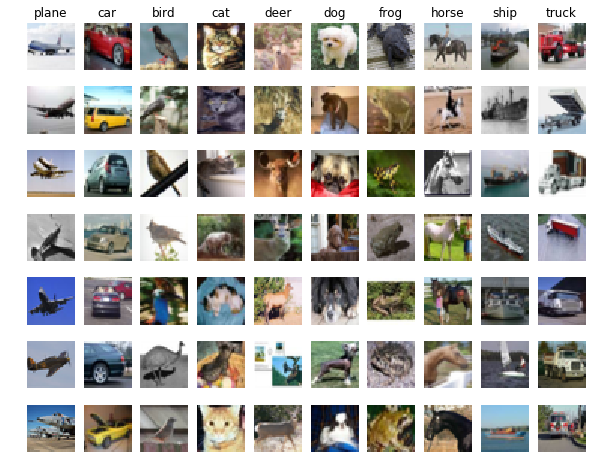

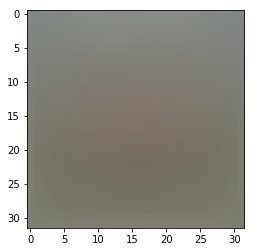

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import math
from cs231n.classifiers.linear_classifier import *
import random
from cs231n.data_utils import load_CIFAR10

# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape     # (50000,32,32,3)
print 'Training labels shape: ', y_train.shape   # (50000L,)
print 'Test data shape: ', X_test.shape          # (10000,32,32,3)
print 'Test labels shape: ', y_test.shape        # (10000L,)
print

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 
                'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):    
    idxs = np.flatnonzero(y_train == y)    
    idxs = np.random.choice(idxs, samples_per_class, replace=False) 
    for i, idx in enumerate(idxs):        
        plt_idx = i * num_classes + y + 1 
        plt.subplot(samples_per_class, num_classes, plt_idx)   
        plt.imshow(X_train[idx].astype('uint8'))        
        plt.axis('off')       
        if i == 0:            
            plt.title(cls)
plt.show()

# Split the data into train, val, and test sets.
num_training = 49000
num_validation = 1000
num_test = 1000
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]                  # (1000,32,32,3)
y_val = y_train[mask]                  # (1,1000)
mask = range(num_training)
X_train = X_train[mask]                # (49000,32,32,3)
y_train = y_train[mask]                # (1,49000)
mask = range(num_test)
X_test = X_test[mask]                  # (1000,32,32,3)
y_test = y_test[mask]                  # (1,1000)

# Preprocessing1: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))    # (49000,3072)
X_val = np.reshape(X_val, (X_val.shape[0], -1))          # (1000,3072)
X_test = np.reshape(X_test, (X_test.shape[0], -1))       # (1000,3072)

# Preprocessing2: subtract the mean image
mean_image = np.mean(X_train, axis=0)       # (1,3072)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# Visualize the mean image
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape((32, 32, 3)).astype('uint8'))
plt.show()

# Bias trick, extending the data
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])    # (49000,3073)
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])          # (1000,3073)
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])       # (1000,3073)

# Use the validation set to tune hyperparameters (regularization strength 
# and learning rate).
learning_rates = [1e-7, 5e-5]
regularization_strengths = [5e4, 1e5]
results = {}
best_val = -1    # The highest validation accuracy that we have seen so far.
best_softmax = None   # The LinearSVM object that achieved the highest validation rate.
iters = 1500
for lr in learning_rates:
    for rs in regularization_strengths:    
        softmax = Softmax()    
        softmax.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=iters)    
        Tr_pred = softmax.predict(X_train.T)    
        acc_train = np.mean(y_train == Tr_pred)    
        Val_pred = softmax.predict(X_val.T)    
        acc_val = np.mean(y_val == Val_pred)    
        results[(lr, rs)] = (acc_train, acc_val)    
        if best_val < acc_val:
            best_val = acc_val
            best_softmax = softmax



In [ ]:
# print results
for lr, reg in sorted(results):    
    train_accuracy, val_accuracy = results[(lr, reg)]    
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy)
print 'Best validation accuracy achieved during validation: %f' % best_val # around 38.2%

# Visualize the learned weights for each class
w = best_softmax.W[:-1, :]   # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):    
    plt.subplot(2, 5, i + 1)    
    # Rescale the weights to be between 0 and 255    
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)    
    plt.imshow(wimg.astype('uint8'))    
    plt.axis('off')    
    plt.title(classes[i])
    plt.show()

# Evaluate the best svm on test set
Ts_pred = best_softmax.predict(X_test.T)
test_accuracy = np.mean(y_test == Ts_pred)     # around 37.1%
print 'LinearSVM on raw pixels of CIFAR-10 final test set accuracy: %f' % test_accuracy